# 상태 진단 알고리즘

## 데이터전처리

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cProfile import label
import torch 
import torch.nn as nn 
import numpy as np 
import pandas as pd 
import os 
import sys 
import random 
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix


### Data generator

In [79]:
def label_generation(mu_s,var_s,label,size,col_name):
    total_label = [] 

    n_col = len(col_name)
    for i in range(n_col):
        mu = mu_s[i]
        var = var_s[i]
        temp = np.random.normal(loc = mu, scale =var, size = (size))
        total_label.append(temp)
    df = pd.DataFrame(total_label).T
    df.columns = col_name
    df['state'] = label

    return df

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20400\3521912812.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_label[data_label['motor']>=100]['motor'] = 100


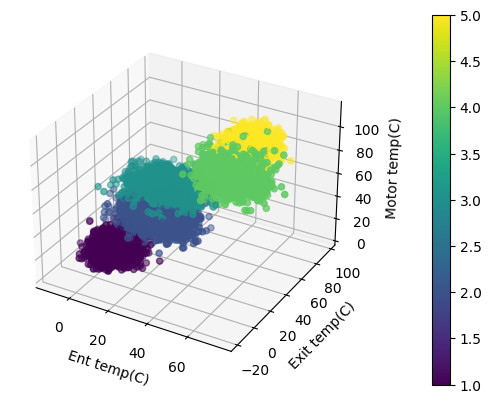

In [80]:
total_mu_s = [[7,10,20],[20,30,40],[20,40,60],[50,50,80],[50,70,90]]
total_var_s = [[5,8,5],[8,8,6],[8,8,5],[7,8,8],[5,8,5]]
total_label = [1,2,3,4,5]
total_size = [2000,2000,2000,2000,2000]
col_name = ['ent','exit','motor']

label_range = 5
temp_data = [] 
for i in range(label_range):
    assert len(total_mu_s) == len(total_var_s) == len(total_label) == len(total_size), "the length should be same!!" 
    mu_s = total_mu_s[i]
    var_s = total_var_s[i]
    label = total_label[i]
    size = total_size[i]
    assert len(mu_s) == len(var_s) == len(col_name), ' the length should be equal to the col name size!!!'
    temp_data.append(label_generation(mu_s,var_s,label,size,col_name))

data_label = pd.concat(temp_data,ignore_index=True)

data_label.tail()
data_label[data_label['ent']>=90]['ent'] = 90
data_label[data_label['exit']>=100]['exit'] = 100
data_label[data_label['motor']>=100]['motor'] = 100

color_dict = {1:'red', 2:'blue', 3:'green', 4:'yellow', 5:'black'}

data_label.replace({"state": color_dict})
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(data_label['ent'], data_label['exit'], data_label['motor'], c=data_label['state'])
ax.set_xlabel('Ent temp(C)')
ax.set_ylabel('Exit temp(C)')
ax.set_zlabel('Motor temp(C)')
fig.colorbar(p, pad=0.15)
plt.show()

data_label.to_csv('./data/data_label.csv', index=False)

In [81]:
MT_label.isnull().sum()
MT_label


,ent,exit,motor,state
0,26.532719,20.122768,14.014863,1
1,-5.638414,2.019925,18.805045,1
2,-3.378261,23.158181,16.764139,1
3,-1.113203,20.861648,18.909047,1
4,-6.026343,14.783084,20.840171,1
...,...,...,...,...
9995,26.397582,84.721843,88.829828,5
9996,30.428702,67.661525,84.510451,5
9997,4.602810,44.340606,96.080824,5
9998,36.366353,74.491762,105.765498,5


## 부품상태 진단

### 모델 학습, 분류

#### MPL classification

In [109]:
device = "cpu"
MT = pd.read_csv('./data/data_label.csv')
scaler = StandardScaler()
X, y = scaler.fit_transform(np.array(MT.iloc[:,:-1])), np.array(MT.iloc[:,-1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape(-1,3)
y_train = y_train.reshape(-1,1)-1
X_test = X_test.reshape(-1,3)
y_test = y_test.reshape(-1,1)-1


In [114]:
# ===============  Training dataset setting==============  #   

learning_rate = 0.001
batch = 100 

class CustomDataset(Dataset):
    def __init__(self):
        self.x_data = torch.FloatTensor(X_train)
        self.y_data = torch.FloatTensor(y_train)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]

        return x, y

class CustomDataset2(Dataset):
    def __init__(self):
        self.x_data = torch.FloatTensor(X_test)
        self.y_data = torch.FloatTensor(y_test)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]

        return x, y


train_dataset = CustomDataset()
test_dataset = CustomDataset2()

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch,shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch ,shuffle = True
)

In [121]:
# =============== MLP classifier ==============  #  
  
class MLP_classifier(nn.Module):
    def __init__(self,input_size,output_size, hidden):
        super(MLP_classifier, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden)
        self.fc2 = nn.Linear(hidden , hidden )
        self.fc3 = nn.Linear(hidden, output_size)


    def forward(self, x):

        x_1 = F.relu(self.fc1(x))
        x_2 = F.relu(self.fc2(x_1))
        x_3 = F.relu(self.fc3(x_2))

        return x_3

In [124]:
X, y = next(iter(train_loader))

input_size = 3 
output_size = 5 
hidden = 128

model = MLP_classifier(input_size, output_size,hidden).to(device)
optimizer = optim.Adam(
            model.parameters(), lr=0.005, eps=1e-10)
criterion = nn.CrossEntropyLoss()

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

n_epoch = 200


for epoch in range(n_epoch):

    train_loss_total = 0
    test_loss_total = 0 
    for i, (input, label) in enumerate(train_loader):
        input = input.to(device)
        label = label.to(device).to(torch.int64)
        result = model(input)
        train_loss = criterion(result, label.squeeze(dim=-1))

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_loss_total+=train_loss.item()

    for i, (input, label) in enumerate(test_loader):
        input = input.to(device)
        label = label.to(device).to(torch.int64)
        result = model(input)
        test_loss = criterion(result, label.squeeze(dim=-1))
        test_loss_total+=test_loss.item()*input.shape[0]
    
    test_loss_avg = test_loss_total/len(test_loader.dataset)

    if epoch%10 ==0:
        print(f'Epoch: {epoch+1:02} | Test Loss: {test_loss_avg:.4f}')

Epoch: 01 | Test Loss: 0.4228
Epoch: 11 | Test Loss: 0.4128
Epoch: 21 | Test Loss: 0.4213
Epoch: 31 | Test Loss: 0.4077
Epoch: 41 | Test Loss: 0.4134
Epoch: 51 | Test Loss: 0.1210
Epoch: 61 | Test Loss: 0.1309
Epoch: 71 | Test Loss: 0.1288
Epoch: 81 | Test Loss: 0.1214
Epoch: 91 | Test Loss: 0.1280
Epoch: 101 | Test Loss: 0.1299
Epoch: 111 | Test Loss: 0.1258
Epoch: 121 | Test Loss: 0.1315
Epoch: 131 | Test Loss: 0.1372
Epoch: 141 | Test Loss: 0.1360
Epoch: 151 | Test Loss: 0.1343
Epoch: 161 | Test Loss: 0.1566
Epoch: 171 | Test Loss: 0.1475
Epoch: 181 | Test Loss: 0.1386
Epoch: 191 | Test Loss: 0.1470


In [125]:
y_pred = torch.argmax(model(torch.FloatTensor(X_test).to(device)), dim=1)
y_true = y_test.reshape(-1)
y_pred = np.array(y_pred)
y_true = np.array(y_true)

print("recall_score: %f " % (recall_score(y_true, y_pred, average='macro')))
print("precision_score: %f " % (precision_score(y_true, y_pred, average='macro')))
print("accuracy_score: %f " % (accuracy_score(y_true, y_pred)))

recall_score: 0.956454 
precision_score: 0.956312 
accuracy_score: 0.956500 


#### SVM classification

In [93]:
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

MT = pd.read_csv('./data/data_label.csv')
scaler = StandardScaler()
features_standardized = scaler.fit_transform(MT.iloc[:,:-1])

X_train, X_test, y_train, y_test = train_test_split(features_standardized, MT.iloc[:,-1], test_size=0.2, random_state=42)

X_train = np.array(X_train).reshape(-1,3)
y_train = np.array(y_train).reshape(-1,1)-1
X_test = np.array(X_test).reshape(-1,3)
y_test = np.array(y_test).reshape(-1,1)-1

svc = SVC(kernel="linear", class_weight="balanced", C=1.0, random_state=0)
model = svc.fit(X_train, y_train)
label_predict = model.predict(X_test)
cf = confusion_matrix(y_test, label_predict)


print("recall_score: %f " % (recall_score(y_test, label_predict, average='macro')))
print("precision_score: %f " % (precision_score(y_test, label_predict, average='macro')))
print("accuracy_score: %f " % (accuracy_score(y_test, label_predict)))

recall_score: 0.958113 
precision_score: 0.957882 
accuracy_score: 0.958000 


c:\Python\python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### 부품상태예측

#### 상태 전이 행렬 구성

In [94]:
import numpy as np

def Item_opt(N, min_cond,r,perc): 
    """
    N: the number of products at each state 
    min_cond: minimum condition of each product for counting 
    r: ratio for probability metrix 
    perc: percentile for counting 
    """
    # P1 is one of the example probability matrix, this part should be done on hand
    P1 = np.array([0.69*r,0.31*r,0.00,0.00,0.00,
                   0.00,0.77*r,0.23*r,0.00,0.00,
                   0.00,0.00,0.92*r,0.08*r,0.00,
                   0.00,0.00,0.00,0.60*r,0.40*r,
                   0.00,0.00,0.00,0.00,1.00*r]).reshape(5,5) 
    assert len(N) == len(P1), ' the length should be equal ! '

    x = N
    T = 0 
    while True:
        x = np.dot(x,P1)
        ratio_x = x/np.sum(x)
        if ratio_x[-6+min_cond]>perc: 
            break
        T+=1
    return ratio_x, T

In [101]:
final = np.array([sum(y_pred == i) for i in range(5)])

In [103]:
#N = np.array([2000,2000,2000,2000,2000])
N = np.array(final)
min_cond = 5 # recommend 5  
r = 1 
perc = 0.7
_, T = Item_opt(N,min_cond,r,perc)
print("Mileage = %d" %(T*10000))

Mileage = 150000
